***
<font size="6"><center><b> B-CNN: MNIST Model B </b></center></font>
***

# Imports Necessary libraries

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
    #import other libraries
import math
import random

sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

DONE loading MixUp Data generator
DONE loading MixUp Data generator


## LOG File Directory

In [2]:
base_path = "./logs/B_CNN"
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print("FOLDER CREATED = ", base_path)
else:
    print("Warning: Folder already exist.")

FOLDER CREATED =  ./logs/B_CNN


### For GPU growth (not required if GPU does not give any error)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Done: GPU "+str(gpu))
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [4]:
def scheduler(epoch):
    learning_rate_init = 0.003
    if epoch > 40:
        learning_rate_init = 0.0005
    if epoch > 50:
        learning_rate_init = 0.0001
    return learning_rate_init

In [5]:
class LossWeightsModifier(keras.callbacks.Callback):
    def __init__(self, beta, gamma):
        self.beta = beta
        self.gamma = gamma
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 8:
            K.set_value(self.beta, 0.6)
            K.set_value(self.gamma, 0.4)
        if epoch == 18:
            K.set_value(self.beta, 0.2)
            K.set_value(self.gamma, 0.8)
        if epoch == 28:
            K.set_value(self.beta, 0)
            K.set_value(self.gamma, 1)

In [6]:
#-------- dimensions ---------
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
#-----------------------------

train_size = 60000

#--- coarse 1 classes ---
num_c = 2
#--- fine classes ---
num_classes  = 47

batch_size   = 128
epochs       = 100

#--- file paths ---
log_filepath = base_path+'/tb_logs/'
weights_store_filepath = base_path+'/model_weights/'
train_id = '1'
model_name = 'EMNIST_model_B_'+train_id+'.h5'
model_path = os.path.join(weights_store_filepath, model_name)

In [7]:
#-------------------- data loading ----------------------
from emnist import list_datasets, extract_training_samples, extract_test_samples
print(list_datasets()) ## PRINT contents of the datasets

x_train, y_train = extract_training_samples('balanced')
print('Complete loading training samples as: x_train, y_train')
x_test, y_test = extract_test_samples('balanced')
print('Complete loading test samples as: x_test, y_test')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#---------------- data preprocessiong -------------------
x_train = (x_train-np.mean(x_train)) / np.std(x_train)
x_test = (x_test-np.mean(x_test)) / np.std(x_test)

#---------------------- make coarse 2 labels --------------------------
parent_f = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1,
            21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1,31:1,32:1,33:1,34:1,35:1,36:1,37:1,38:1,39:1,
            40:1,41:1,42:1,43:1,44:1,45:1,46:1}
y_c_train = np.zeros((y_train.shape[0], num_c)).astype("float32")
y_c_test = np.zeros((y_test.shape[0], num_c)).astype("float32")
for i in range(y_c_train.shape[0]):
    y_c_train[i][parent_f[np.argmax(y_train[i])]] = 1.0
for i in range(y_c_test.shape[0]):
    y_c_test[i][parent_f[np.argmax(y_test[i])]] = 1.0

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']
Complete loading training samples as: x_train, y_train
Complete loading test samples as: x_test, y_test


<font color='red'><h2 align="left"> REDUCED DATASET FOR FAST TRAINING </h2>
(**DON'T USE WHILE TRAINING THE MODEL || __RECONSTRUCTED IMAGE WILL BE Blurry__**)
(**Training on 1000 Data || Testing on 100 Data**)

In [8]:
print("TRAIN: \r\n")
print(x_train.shape)
print(y_train.shape)
print(y_c_train.shape)

print("\nTEST: \r\n")
print(x_test.shape)
print(y_test.shape)
print(y_c_test.shape)

TRAIN: 

(112800, 28, 28)
(112800, 47)
(112800, 2)

TEST: 

(18800, 28, 28)
(18800, 47)
(18800, 2)


In [9]:
#----------------------- model definition ---------------------------
beta = K.variable(value=0.98, dtype="float32", name="beta") # A2 in paper
gamma = K.variable(value=0.02, dtype="float32", name="gamma") # A3 in paper

In [10]:
img_input = Input(shape=input_shape, name='input')

#--- block 1 ---
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#--- coarse 1 branch ---
c_1_bch = Flatten(name='c1_flatten')(x)
c_1_bch = Dense(64, activation='relu', name='c1_fc_cifar10_1')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_pred = Dense(num_c, activation='softmax', name='c1_predictions_cifar10')(c_1_bch)

#--- block 3 ---
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#--- fine block ---
x = Flatten(name='flatten')(x)
x = Dense(128, activation='relu', name='fc_cifar10_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
fine_pred = Dense(num_classes, activation='softmax', name='predictions_cifar10')(x)

In [11]:
model = Model(img_input, [c_1_pred, fine_pred], name='medium_dynamic')

In [12]:
model.summary()

Model: "medium_dynamic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 32)   320         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 14, 14, 32)   0           ['batch_normalizatio

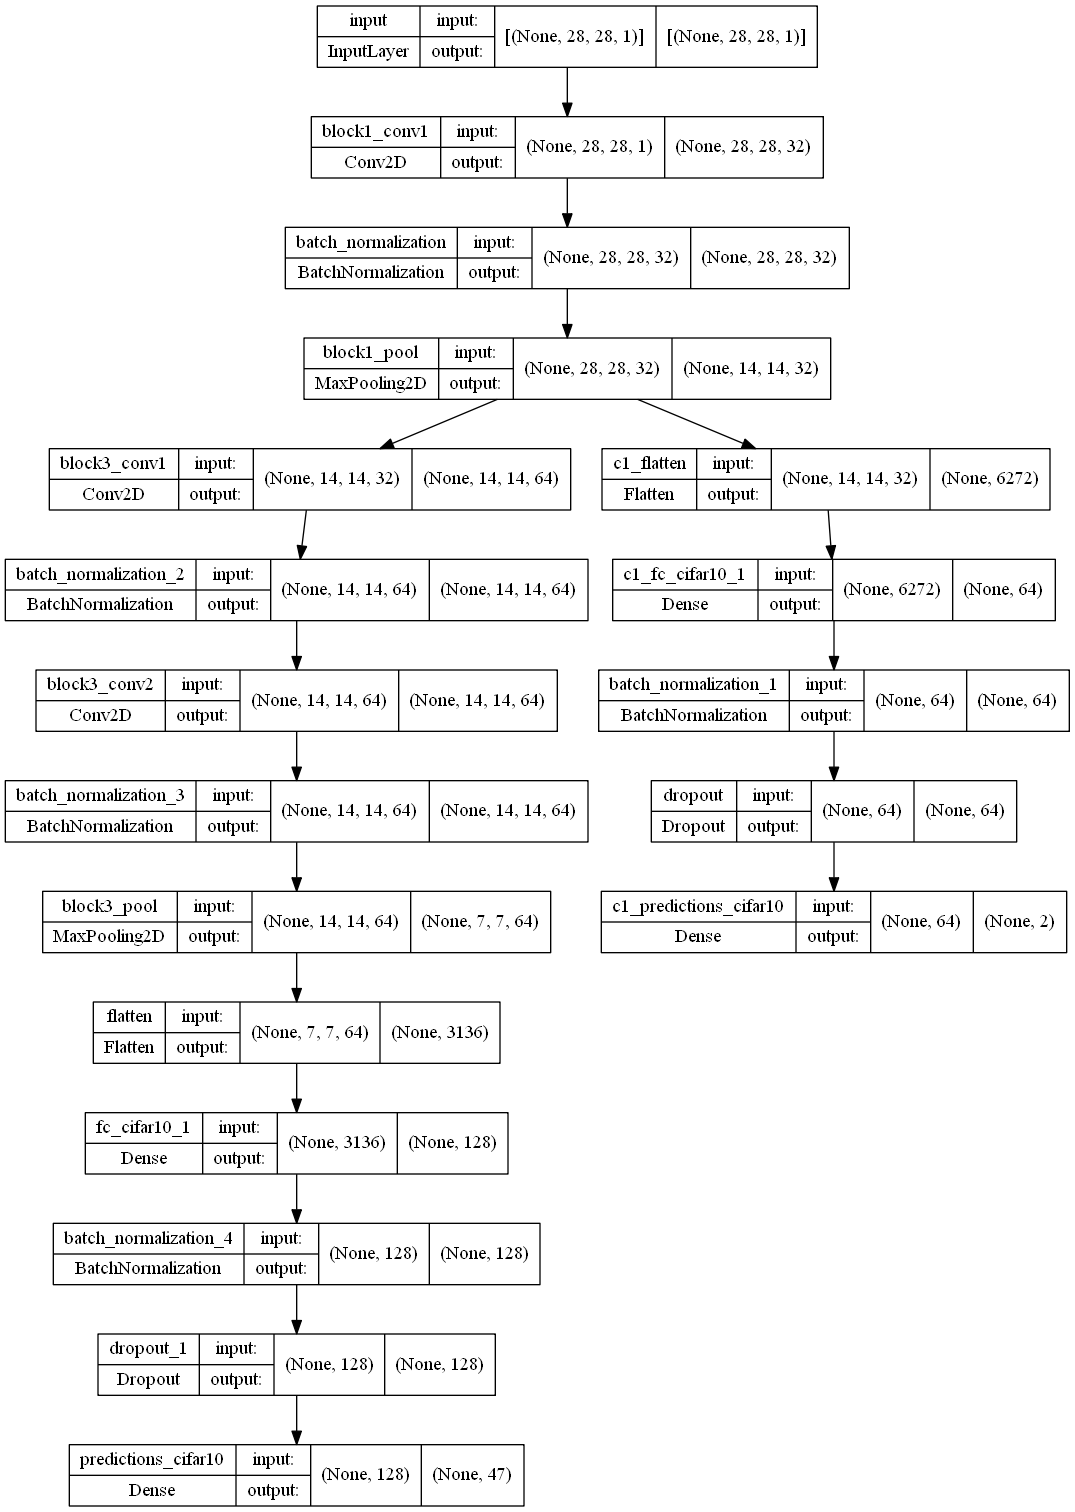

In [14]:
keras.utils.plot_model(model, base_path+"/Architecture.png",show_shapes=True)

In [15]:
#----------------------- compile and fit ---------------------------
sgd = optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              loss_weights=[beta, gamma],
              # optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(beta, gamma)
cbks = [change_lr, tb_cb, change_lw]

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
try:
    model.load_weights(base_path+'/trainded_model.h5')
except:
    model.fit(x_train, [y_c_train, y_train],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=cbks,
              validation_data=(x_test, [y_c_test, y_test]))
    model.save(base_path+'/trainded_model.h5')

In [18]:
score = model.evaluate(x_test, [y_c_test, y_test], verbose=1)
# model.save_weights(model_path)
print('score is: ', score)

588/588 [==============================] - 6s 10ms/step - loss: 0.1670 - c1_predictions_cifar10_loss: 0.1635 - predictions_cifar10_loss: 0.3393 - c1_predictions_cifar10_accuracy: 0.9271 - predictions_cifar10_accuracy: 0.8876
score is:  [0.1670246124267578, 0.16350868344306946, 0.3392989933490753, 0.9271276593208313, 0.8876063823699951]


In [19]:
for n in range(len(score)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', score[n])

1. loss ==> 0.1670246124267578
2. c1_predictions_cifar10_loss ==> 0.16350868344306946
3. predictions_cifar10_loss ==> 0.3392989933490753
4. c1_predictions_cifar10_accuracy ==> 0.9271276593208313
5. predictions_cifar10_accuracy ==> 0.8876063823699951


# Level-Wise Performance

In [21]:
predictions = model.predict(x_test, verbose=1)

588/588 [==============================] - 3s 6ms/step


{0, 1}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
[0, 1]
['0', '1']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']

  • multilabel-Confusion_Matrix 


  • COARSE LEVEL 
[[[14280   520]
  [  850  3150]]

 [[ 3150   850]
  [  520 14280]]]

  • FINE LEVEL 
[[[18262   138]
  [  120   280]]

 [[18171   229]
  [  124   276]]

 [[18355    45]
  [   36   364]]

 [[18397     3]
  [    7   393]]

 [[18380    20]
  [   29   371]]

 [[18383    17]
  [   43   357]]

 

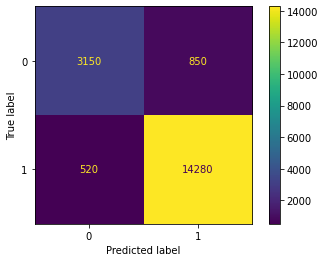

              precision    recall  f1-score   support

           0    0.85831   0.78750   0.82138      4000
           1    0.94382   0.96486   0.95423     14800

    accuracy                        0.92713     18800
   macro avg    0.90107   0.87618   0.88780     18800
weighted avg    0.92563   0.92713   0.92596     18800


  • FINE LEVEL 


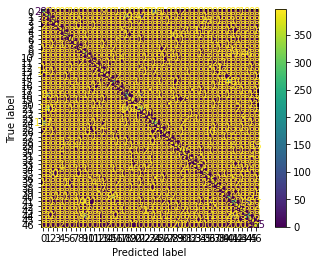

              precision    recall  f1-score   support

           0    0.66986   0.70000   0.68460       400
           1    0.54653   0.69000   0.60994       400
           2    0.88998   0.91000   0.89988       400
           3    0.99242   0.98250   0.98744       400
           4    0.94885   0.92750   0.93805       400
           5    0.95455   0.89250   0.92248       400
           6    0.93812   0.94750   0.94279       400
           7    0.96806   0.98500   0.97646       400
           8    0.94307   0.95250   0.94776       400
           9    0.69032   0.80250   0.74220       400
          10    0.97500   0.97500   0.97500       400
          11    0.96517   0.97000   0.96758       400
          12    0.96429   0.94500   0.95455       400
          13    0.93216   0.92750   0.92982       400
          14    0.97761   0.98250   0.98005       400
          15    0.70588   0.63000   0.66579       400
          16    0.93447   0.96250   0.94828       400
          17    0.95792   0

In [22]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


coarse_classes_number = num_c #from model architecture
fine_classes_number = num_classes

y_true_coarse = np.argmax(y_c_test, axis=1)
y_pred_coarse = np.argmax(predictions[0], axis=1)

y_true_fine = np.argmax(y_test, axis=1)
y_pred_fine = np.argmax(predictions[1], axis=1)

output = set()
for x in y_true_coarse:
    output.add(x)
print(output)


for x in y_true_fine:
    output.add(x)
print(output)

coarse_labels = list(range(0, coarse_classes_number))
coarse_target_names = [str(x) for x in list(range(0, coarse_classes_number))]

fine_labels = list(range(0, fine_classes_number))
fine_target_names = [str(x) for x in list(range(0, fine_classes_number))]
print(coarse_labels)
print(coarse_target_names)

print(fine_labels)
print(fine_target_names)

def confusion_matrixDisplay(y_true, y_pred, target_names):
    labels = target_names
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.show()
    #plt.savefig("Confusion_Matrix.png")

print('\n\033[91m','\033[1m',"\u2022",'multilabel-Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Classification Report','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_coarse, y_pred_coarse, coarse_target_names)
print(classification_report(y_true_coarse, y_pred_coarse, target_names=coarse_target_names, digits=5))

print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_fine, y_pred_fine, fine_target_names)
print(classification_report(y_true_fine, y_pred_fine, target_names=fine_target_names, digits=5))

# hierarchical_PrecisionRecallF1

In [25]:
import sklearn_hierarchical_classification.metrics as HCM
from treelib import Tree
print(HCM.__file__)
print(metrics.__file__)

tree = Tree()
tree.create_node("Root", "root")  # root node
for i in range(coarse_classes_number):
    tree.create_node(i, 'L0_'+ str(i), parent="root")
    
def maketree(coarse_lvl, fine_level):
    
    tree.create_node('fine'+str(fine_level), 'L1_'+str(fine_level), 'L0_' + str(coarse_lvl))
    
for i in range(len(parent_f)):
    maketree(parent_f[i], i)
tree.show()

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn_hierarchical_classification\metrics.py
C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\HDeep_CapsNet\code\Training_and_Analysis\1_EMNIST\../..\src\metrics.py
Root
├── 0
│   ├── fine0
│   ├── fine1
│   ├── fine2
│   ├── fine3
│   ├── fine4
│   ├── fine5
│   ├── fine6
│   ├── fine7
│   ├── fine8
│   └── fine9
└── 1
    ├── fine10
    ├── fine11
    ├── fine12
    ├── fine13
    ├── fine14
    ├── fine15
    ├── fine16
    ├── fine17
    ├── fine18
    ├── fine19
    ├── fine20
    ├── fine21
    ├── fine22
    ├── fine23
    ├── fine24
    ├── fine25
    ├── fine26
    ├── fine27
    ├── fine28
    ├── fine29
    ├── fine30
    ├── fine31
    ├── fine32
    ├── fine33
    ├── fine34
    ├── fine35
    ├── fine36
    ├── fine37
    ├── fine38
    ├── fine39
    ├── fine40
    ├── fine41
    ├── fine42
    ├── fine43
    ├── fine44
    ├── fine45
    └── fine46



In [26]:
true_label = [y_true_coarse.tolist(), y_true_fine.tolist()]
pred_label = [predictions[0],predictions[1]]

In [28]:
h_measurements = metrics.get_hierarchical_metrics(true_label, pred_label, tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2])
print('\nH Accuracy=',
     metrics.get_h_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',)

print('\nM Accuracy=',
     metrics.get_m_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',
      )

print('\nExact_Match=',
     metrics.get_exact_match(true_label, pred_label),
     '\nThis method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.',
      )

print('\nConsistency=',
     metrics.get_consistency(pred_label, tree),
     '\nThis methods estimates the consistency.',
      )


Hierarchical Precision = 0.9099113475177304 
Hierarchical Recall = 0.9248936170212766 
Hierarchical F1-Score = 0.915904255319149

H Accuracy= 0.9069366741108038 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

M Accuracy= 0.9073670212765957 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

Exact_Match= 0.8542553191489362 
This method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.

Consistency= 0.9434574468085106 
This methods estimates the consistency.
